<a href="https://colab.research.google.com/github/NegarMov/MRI-Hippocampus-Segmentation/blob/main/MRI_Hippocampus_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the required packages

In [1]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 240.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=0d881a1e903e38bff9f86538fc25f0376fd4c9fc25f899b2745674183fc53a52
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=c746722134ae6a5fd55dbe90d7397af088db416fde1b84a74627c44e08d61b85
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytor

In [2]:
import kagglehub
import shutil
import os
import random
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim.lr_scheduler as lr_scheduler

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torchvision import transforms

# Define constants

In [3]:
image_size = 256
batch_size = 32
learning_rate = 1e-3
num_epochs = 100

# Set the Random Seed

In [4]:
SEED = 0

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Download the dataset from Kaggle

In [5]:
path = kagglehub.dataset_download("sabermalek/mrihs")

shutil.copytree(path, '/content/dataset')

100%|██████████| 159M/159M [00:01<00:00, 93.2MB/s]

Extracting files...


'/content/dataset'

# Load the images

All the folders are renamed to ensure name consistency. This will make the future steps of loading the dataset easier.

In [6]:
def rename_folders(root_dir):
  for old_dir in os.listdir(root_dir):
    os.rename(
      os.path.join(root_dir, old_dir),
      os.path.join(root_dir, '_'.join(old_dir.split('_')[:5]))
    )

rename_folders('/content/dataset/label/100label')
rename_folders('/content/dataset/label/35label')
rename_folders('/content/dataset/original/100')
rename_folders('/content/dataset/original/35')

Only non-empty masks (masks containing at least one pixel with a value other than that of the background) are chosen.

In [7]:
def valid_mask(image_path):
    img = Image.open(image_path).convert('L')
    pixels = img.getdata()
    return np.min(pixels) != np.max(pixels)

In [8]:
def load_images_from_folder(image_dir, label_dir):
  images_path = []
  labels_path = []

  for filename in os.listdir(label_dir):
    left_dir = os.path.join(label_dir, filename, filename + '_L')
    right_dir = os.path.join(label_dir, filename, filename + '_R')
    img_dir = os.path.join(image_dir, filename)

    # check if all the needed directories exist, if not, skip the file
    if not (os.path.isdir(left_dir) and os.path.isdir(right_dir) and os.path.isdir(img_dir)):
      print(f'skipped {filename}...')
      continue

    # rename image files to ensure consistent file names
    for label in os.listdir(left_dir):
      os.rename(os.path.join(left_dir, label), os.path.join(left_dir, label.split('_')[-1]))
    for label in os.listdir(right_dir):
      os.rename(os.path.join(right_dir, label), os.path.join(right_dir, label.split('_')[-1]))
    for img in os.listdir(img_dir):
      os.rename(os.path.join(img_dir, img), os.path.join(img_dir, img.split('_')[-1]))

    for id in os.listdir(left_dir):
      left_label = os.path.join(left_dir, id)
      right_label = os.path.join(right_dir, id)
      img = os.path.join(img_dir, id)

      if valid_mask(left_label) or valid_mask(right_label):
        images_path.append(img)
        labels_path.append((left_label, right_label))

  return images_path, labels_path

In [9]:
train_images, train_labels = load_images_from_folder('/content/dataset/original/100', '/content/dataset/label/100label')
test_images, test_labels = load_images_from_folder('/content/dataset/original/35', '/content/dataset/label/35label')

len(train_images), len(test_images)

skipped ADNI_013_S_0325_85153...


(2969, 1055)

# Create the dataset

In [10]:
class MRI_Dataset(Dataset):
  def __init__(self, images, labels):
    self.images = images
    self.labels = labels


  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img_path = self.images[idx]
    image = Image.open(img_path).convert('RGB')

    label_path = self.labels[idx]
    mask1 = cv2.imread(label_path[0], cv2.IMREAD_GRAYSCALE)
    mask2 = cv2.imread(label_path[1], cv2.IMREAD_GRAYSCALE)
    label = cv2.bitwise_or(mask1, mask2)

    return {
      "images": image,
      "labels": Image.fromarray(label)
    }

The wrapper dataset handles the application of different transformation functions to the training, validation, and test sets.

In [24]:
class RotateTransform:
    def __init__(self, angle_range):
        self.angle_range = angle_range

    def __call__(self, img, mask):
        angle = random.uniform(*self.angle_range)
        img_rotated = img.rotate(angle)
        mask_rotated = mask.rotate(angle)
        return img_rotated, mask_rotated

class WrapperDataset:
  def __init__(self, dataset, dataset_type):
    self.dataset = dataset

    self.label_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x > 0.5).float())
    ])

    self.base_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    self.aug_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    self.crop = transforms.RandomResizedCrop(size=(image_size, image_size), scale=(0.9, 1.0))

    self.rotate = RotateTransform(angle_range=(-5, 5))

    self.dataset_type = dataset_type

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    images = self.dataset[index]["images"]
    labels = self.dataset[index]["labels"]

    # apply data augmentation
    if self.dataset_type == 'train':
      if random.random() < 0.5:
        images = images.transpose(Image.FLIP_LEFT_RIGHT)
        labels = labels.transpose(Image.FLIP_LEFT_RIGHT)

      if random.random() < 0.5:
        pad_amount = tuple(random.randint(0, 20) for _ in range(4))
        images = transforms.functional.pad(images, pad_amount)
        labels = transforms.functional.pad(labels, pad_amount)

      if random.random() < 0.5:
        i, j, h, w = self.crop.get_params(images, (0.95, 1.0), (1, 1))
        images = transforms.functional.crop(images, i, j, h, w)
        labels = transforms.functional.crop(labels, i, j, h, w)

      if random.random() < 0.5:
        images, labels = self.rotate(images, labels)

    return {
      "images": self.aug_transform(images) if self.dataset_type == 'train' else self.base_transform(images),
      "labels": self.label_transform(labels)
    }

In [12]:
train_val_dataset = MRI_Dataset(train_images, train_labels)

train_idx, val_idx = train_test_split(
  np.arange(len(train_val_dataset)),
  test_size=0.2,
  random_state=SEED,
  shuffle=True
)

train_dataset = WrapperDataset(Subset(train_val_dataset, train_idx), 'train')
val_dataset = WrapperDataset(Subset(train_val_dataset, val_idx), 'val')
test_dataset = WrapperDataset(MRI_Dataset(test_images, test_labels), 'test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

len(train_dataset), len(val_dataset), len(test_dataset)

(2375, 594, 1055)

# Set up the model

In [13]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.unet = smp.Unet(
            encoder_name="efficientnet-b0",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
        )

    def forward(self, img):
        out = self.unet(img)

        return out

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [25]:
def initiate_model():
  model = UNet()
  model.to(device)

  criterion = (DiceLoss(mode="binary"), nn.BCEWithLogitsLoss())

  optimizer = torch.optim.Adam(
      model.parameters(),
      lr=learning_rate,
  )

  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
      optimizer,
      mode='max',
      threshold=1e-3,
      patience=2,
      factor=0.5,
  )

  return model, criterion, optimizer, scheduler

# Train the model

In [16]:
def dice_score(preds, targets, eps=1e-8):
    preds = (preds.sigmoid() > 0.5).float()

    intersection = (preds * targets).sum()

    return (2. * intersection + eps) / (preds.sum() + targets.sum() + eps)

In [26]:
model, criterion, optimizer, scheduler = initiate_model()

train_loss, train_dice = [], []
val_loss, val_dice = [], []

for e in tqdm(range(num_epochs)):

  if scheduler.get_last_lr()[-1] < learning_rate * (0.5 ** 4):
        break

  # training
  model.train()

  avg_loss, avg_dice, total_samples = 0, 0, 0
  for train_data in train_loader:

    img_train = train_data["images"].to(device)
    label_train = train_data["labels"].to(device)

    optimizer.zero_grad()

    label_pred = model(img_train)

    loss = criterion[0](label_pred, label_train) + criterion[1](label_pred, label_train)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    avg_loss += loss.item()
    avg_dice += dice_score(label_pred, label_train).item()
    total_samples += len(img_train)

  train_loss.append(avg_loss / len(train_loader))
  train_dice.append(avg_dice / len(train_loader))

  # evaluation
  model.eval()
  with torch.no_grad():
    avg_loss, avg_dice, total_samples = 0, 0, 0
    for val_data in val_loader:

      img_val = val_data["images"].to(device)
      label_val = val_data["labels"].to(device)

      label_pred = model(img_val)

      loss = criterion[0](label_pred, label_val) + criterion[1](label_pred, label_val)

      avg_loss += loss.item()
      avg_dice += dice_score(label_pred, label_val).item()
      total_samples += len(img_val)

    val_loss.append(avg_loss / len(val_loader))
    val_dice.append(avg_dice / len(val_loader))

  print(f"\nLR: {scheduler.get_last_lr()}")
  print(f"Train Loss: {train_loss[-1]} - Validation Loss: {val_loss[-1]}")
  print(f"Train Dice Score: {train_dice[-1]} - Validation Dice Score: {val_dice[-1]}")

  scheduler.step(val_dice[-1])

  1%|          | 1/100 [00:50<1:23:16, 50.47s/it]


LR: [0.001]
Train Loss: 1.084290826320648 - Validation Loss: 0.7484531245733562
Train Dice Score: 0.32829257268556794 - Validation Dice Score: 0.6923945797117133


  2%|▏         | 2/100 [01:41<1:22:32, 50.53s/it]


LR: [0.001]
Train Loss: 0.3415382128953934 - Validation Loss: 0.2750599980354309
Train Dice Score: 0.773991851011912 - Validation Dice Score: 0.7796288226780138


  3%|▎         | 3/100 [02:32<1:22:10, 50.83s/it]


LR: [0.001]
Train Loss: 0.19149698515733082 - Validation Loss: 0.19206018981180692
Train Dice Score: 0.8314147337277731 - Validation Dice Score: 0.826379700710899


  4%|▍         | 4/100 [03:23<1:21:49, 51.15s/it]


LR: [0.001]
Train Loss: 0.1648715353012085 - Validation Loss: 0.17551004886627197
Train Dice Score: 0.8503281466166178 - Validation Dice Score: 0.8443708357058073


  5%|▌         | 5/100 [04:15<1:21:00, 51.16s/it]


LR: [0.001]
Train Loss: 0.15869247098763783 - Validation Loss: 0.1515920075931047
Train Dice Score: 0.8542166535059611 - Validation Dice Score: 0.860256995025434


  6%|▌         | 6/100 [05:06<1:20:10, 51.17s/it]


LR: [0.001]
Train Loss: 0.15017462213834126 - Validation Loss: 0.14623131759856878
Train Dice Score: 0.8611758859952291 - Validation Dice Score: 0.8667486560972113


  7%|▋         | 7/100 [05:57<1:19:34, 51.34s/it]


LR: [0.001]
Train Loss: 0.14704849123954772 - Validation Loss: 0.14745298027992249
Train Dice Score: 0.8636451029777527 - Validation Dice Score: 0.8633225685671756


  8%|▊         | 8/100 [06:48<1:18:33, 51.23s/it]


LR: [0.001]
Train Loss: 0.14207738280296325 - Validation Loss: 0.14032565527840665
Train Dice Score: 0.8678985079129536 - Validation Dice Score: 0.8696220517158508


  9%|▉         | 9/100 [07:40<1:17:39, 51.20s/it]


LR: [0.001]
Train Loss: 0.1395648454626401 - Validation Loss: 0.1350840863428618
Train Dice Score: 0.8701246317227681 - Validation Dice Score: 0.874660284895646


 10%|█         | 10/100 [08:31<1:16:44, 51.16s/it]


LR: [0.001]
Train Loss: 0.13724258452653884 - Validation Loss: 0.13974340456096748
Train Dice Score: 0.8721178046862285 - Validation Dice Score: 0.8714888786014757


 11%|█         | 11/100 [09:22<1:15:55, 51.19s/it]


LR: [0.001]
Train Loss: 0.13629008183876673 - Validation Loss: 0.1336487994382256
Train Dice Score: 0.8727612638473511 - Validation Dice Score: 0.8754833779836956


 12%|█▏        | 12/100 [10:13<1:15:03, 51.17s/it]


LR: [0.001]
Train Loss: 0.13256161749362946 - Validation Loss: 0.13714298762773214
Train Dice Score: 0.8761496583620707 - Validation Dice Score: 0.8715917217104059


 13%|█▎        | 13/100 [11:04<1:14:12, 51.17s/it]


LR: [0.0005]
Train Loss: 0.1283689421415329 - Validation Loss: 0.1277189890020772
Train Dice Score: 0.8799896240234375 - Validation Dice Score: 0.8803143595394335


 14%|█▍        | 14/100 [11:55<1:13:21, 51.18s/it]


LR: [0.0005]
Train Loss: 0.12670101900895436 - Validation Loss: 0.12768274271174482
Train Dice Score: 0.8816340708732605 - Validation Dice Score: 0.8806563145235965


 15%|█▌        | 15/100 [12:47<1:12:39, 51.28s/it]


LR: [0.0005]
Train Loss: 0.1251942683259646 - Validation Loss: 0.12580852171308116
Train Dice Score: 0.882926630973816 - Validation Dice Score: 0.8823162630984658


 16%|█▌        | 16/100 [13:39<1:11:57, 51.40s/it]


LR: [0.0005]
Train Loss: 0.12336659401655198 - Validation Loss: 0.12571243706502414
Train Dice Score: 0.884629004796346 - Validation Dice Score: 0.8824485979582134


 17%|█▋        | 17/100 [14:30<1:11:05, 51.39s/it]


LR: [0.0005]
Train Loss: 0.12231275856494904 - Validation Loss: 0.12390763508646112
Train Dice Score: 0.8856488370895386 - Validation Dice Score: 0.884109616279602


 18%|█▊        | 18/100 [15:21<1:10:17, 51.43s/it]


LR: [0.0005]
Train Loss: 0.12112293173869451 - Validation Loss: 0.12333593321473975
Train Dice Score: 0.8867513068517049 - Validation Dice Score: 0.8845792381387008


 19%|█▉        | 19/100 [16:13<1:09:28, 51.46s/it]


LR: [0.0005]
Train Loss: 0.12092104415098825 - Validation Loss: 0.12343572197776091
Train Dice Score: 0.8869655521710714 - Validation Dice Score: 0.8845116119635733


 20%|██        | 20/100 [17:05<1:08:37, 51.47s/it]


LR: [0.0005]
Train Loss: 0.12065097451210022 - Validation Loss: 0.12326340220476452
Train Dice Score: 0.8871463394165039 - Validation Dice Score: 0.884867715208154


 21%|██        | 21/100 [17:56<1:07:49, 51.51s/it]


LR: [0.00025]
Train Loss: 0.1177563523252805 - Validation Loss: 0.12131525615328237
Train Dice Score: 0.8899900364875794 - Validation Dice Score: 0.8864276660116095


 22%|██▏       | 22/100 [18:48<1:06:56, 51.50s/it]


LR: [0.00025]
Train Loss: 0.116742758055528 - Validation Loss: 0.12250676437428124
Train Dice Score: 0.8907867407798767 - Validation Dice Score: 0.8855439738223427


 23%|██▎       | 23/100 [19:39<1:05:59, 51.42s/it]


LR: [0.00025]
Train Loss: 0.11656399190425873 - Validation Loss: 0.12155031922616456
Train Dice Score: 0.8909372035662333 - Validation Dice Score: 0.8859472243409408


 24%|██▍       | 24/100 [20:30<1:05:06, 51.40s/it]


LR: [0.00025]
Train Loss: 0.1153899077574412 - Validation Loss: 0.1194359291540949
Train Dice Score: 0.8920417547225952 - Validation Dice Score: 0.8881447660295587


 25%|██▌       | 25/100 [21:21<1:04:10, 51.34s/it]


LR: [0.00025]
Train Loss: 0.11405506362517674 - Validation Loss: 0.11959291484795119
Train Dice Score: 0.8933827519416809 - Validation Dice Score: 0.8880572977818941


 26%|██▌       | 26/100 [22:13<1:03:16, 51.30s/it]


LR: [0.00025]
Train Loss: 0.11359133243560791 - Validation Loss: 0.12160380145436839
Train Dice Score: 0.8938741898536682 - Validation Dice Score: 0.8863712455096998


 27%|██▋       | 27/100 [23:04<1:02:24, 51.29s/it]


LR: [0.00025]
Train Loss: 0.11418321132659912 - Validation Loss: 0.11938066310004185
Train Dice Score: 0.8931928110122681 - Validation Dice Score: 0.8879803513225756


 28%|██▊       | 28/100 [23:55<1:01:30, 51.26s/it]


LR: [0.000125]
Train Loss: 0.11247928698857625 - Validation Loss: 0.11879092611764606
Train Dice Score: 0.8947253553072612 - Validation Dice Score: 0.8884511684116564


 29%|██▉       | 29/100 [24:46<1:00:41, 51.29s/it]


LR: [0.000125]
Train Loss: 0.11185911943515142 - Validation Loss: 0.11792912765553124
Train Dice Score: 0.8952799081802368 - Validation Dice Score: 0.8897107965067813


 30%|███       | 30/100 [25:37<59:42, 51.18s/it]  


LR: [0.000125]
Train Loss: 0.11098293691873551 - Validation Loss: 0.11828032724167171
Train Dice Score: 0.896093201637268 - Validation Dice Score: 0.8892536508409601


 31%|███       | 31/100 [26:28<58:45, 51.09s/it]


LR: [0.000125]
Train Loss: 0.11261475334564845 - Validation Loss: 0.11805600320038043
Train Dice Score: 0.894629819393158 - Validation Dice Score: 0.8894898483627721


 32%|███▏      | 32/100 [27:19<57:52, 51.07s/it]


LR: [0.000125]
Train Loss: 0.11043381671110789 - Validation Loss: 0.11771654102363084
Train Dice Score: 0.8967395949363709 - Validation Dice Score: 0.8898058627781115


 33%|███▎      | 33/100 [28:10<57:05, 51.13s/it]


LR: [6.25e-05]
Train Loss: 0.11053033451239268 - Validation Loss: 0.11753115450081073
Train Dice Score: 0.8966797510782878 - Validation Dice Score: 0.8898228187310068


 34%|███▍      | 34/100 [29:01<56:11, 51.08s/it]


LR: [6.25e-05]
Train Loss: 0.10964953651030858 - Validation Loss: 0.11701936392407668
Train Dice Score: 0.8975081960360209 - Validation Dice Score: 0.8903185662470365


 35%|███▌      | 35/100 [29:52<55:29, 51.23s/it]


LR: [6.25e-05]
Train Loss: 0.10975331991910935 - Validation Loss: 0.11706119148354781
Train Dice Score: 0.8973052811622619 - Validation Dice Score: 0.8904537966376856


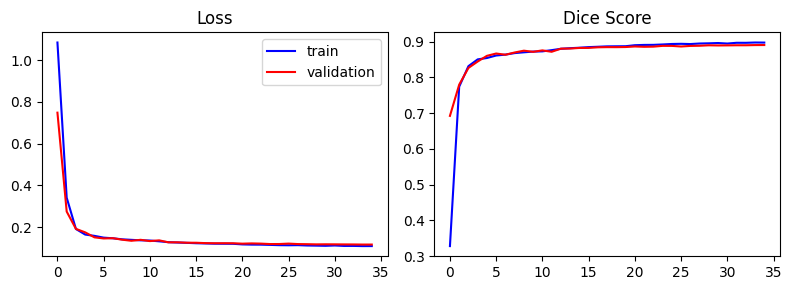

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].set_title("Loss")
axes[0].plot(train_loss, c='b', label='train')
axes[0].plot(val_loss, c='r', label='validation')
axes[0].legend()

axes[1].set_title("Dice Score")
axes[1].plot(train_dice, c='b', label='train')
axes[1].plot(val_dice, c='r', label='validation')

plt.tight_layout()
plt.show()

# Inference

In [28]:
def show_image_set(img_id):
  test_img = Image.open(test_images[img_id]).convert('L')

  test_l = transforms.ToPILImage()(test_dataset[img_id]["labels"]).resize(test_img.size)

  pred = model(test_dataset[img_id]["images"].unsqueeze(0).to(device)).sigmoid()
  test_pred = transforms.ToPILImage()(pred[0]).resize(test_img.size)

  fig, axes = plt.subplots(1, 3, figsize=(6, 2.5))

  axes[0].imshow(test_img, cmap='gray')
  axes[0].set_title("MRI Image")
  axes[0].axis('off')

  axes[1].imshow(test_l, cmap='gray')
  axes[1].set_title("Original Mask")
  axes[1].axis('off')

  axes[2].imshow(test_pred, cmap='gray')
  axes[2].set_title("Predicted Mask")
  axes[2].axis('off')

  plt.tight_layout()
  plt.show()

Show the result for 5 random samples of the test set.

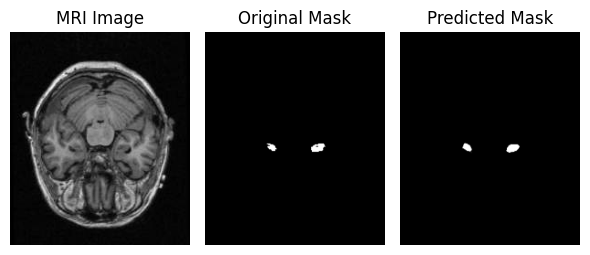

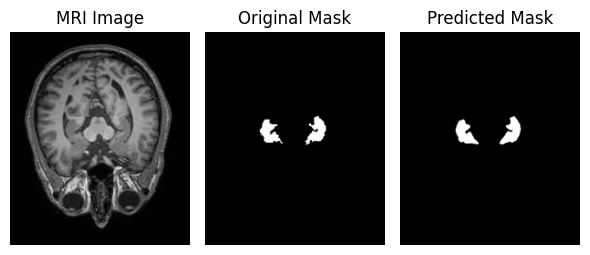

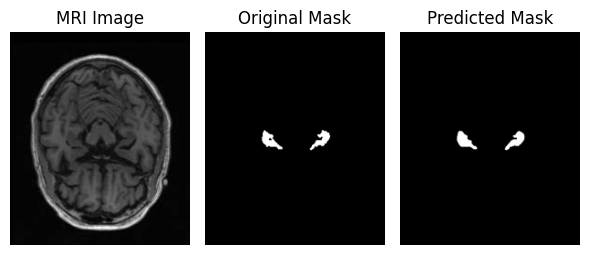

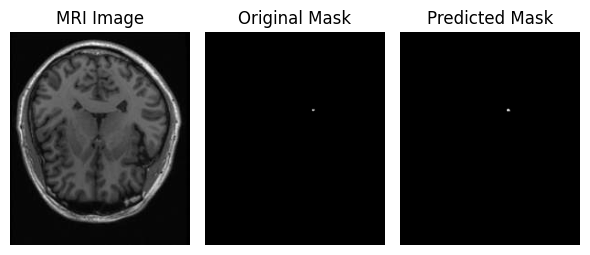

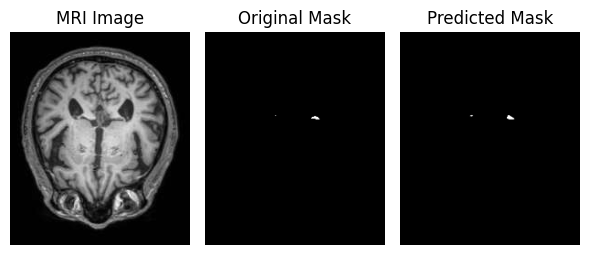

In [31]:
for i in random.sample(range(len(test_dataset)), 5):
  show_image_set(i)

In [30]:
model.eval()
with torch.no_grad():
  avg_dice = 0
  for test_data in test_loader:

    img_test = test_data["images"].to(device)
    label_test = test_data["labels"].to(device)

    label_pred = model(img_test)
    avg_dice += dice_score(label_pred, label_test).item()

print(f"Test Dice Score: {avg_dice / len(test_loader)}")

Test Dice Score: 0.8390602541692329
